In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import gym
import matplotlib.pyplot as plt

from os import path
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

import matplotlib.pyplot as plt

DEFAULT_X = np.pi
DEFAULT_Y = 1.0

In [ ]:
class CartPoleOptimalControlEnv(gym.Env):
    def __init__(self):
        """
        Initialize the environment parameters and action space.
        """
        self.M = 40.0  # Mass of the cart (kg)
        self.mp = 2.0  # Mass of the pole (kg)
        self.L = 0.75  # Length of the pole (m)
        self.g = 10  # Acceleration due to gravity (m/s^2)

        # State space: [cart position (x), cart velocity (x_dot), pole angle (theta), pole angular velocity (theta_dot)]
        POSITIVE_INF = float('inf')  # Define a constant for positive infinity
        NEGATIVE_INF = -float('inf')  # Define a constant for negative infinity
        self.state_space = spaces.Box(low=np.array([NEGATIVE_INF, NEGATIVE_INF, -np.pi, NEGATIVE_INF]),
                                high=np.array([POSITIVE_INF, POSITIVE_INF, np.pi, POSITIVE_INF]))

        # Action space: Force applied to the cart (Fx)
        self.action_space = spaces.Box(low=-2.0, high=2.0)  # Force limits in Newtons

        self.threshold = 195

        # Initial state
        self.reset()

        # Time step (seconds)
        self.dt = 0.02

    def step(self, action):
        """
        Performs one simulation step of the cart-pole system based on the given action.

        Args:
            action: Force applied to the cart (Fx)

        Returns:
            observation (ndarray): The next state of the system.
            reward (float): The reward for the current step.
            done (bool): Whether the episode is finished.
            info (dict): Additional information about the episode.
        """

        # Check if action is within bounds
        if action < self.action_space.low[0] or action > self.action_space.high[0]:
            raise ValueError("Action ({}) out of bounds".format(action))

        # Update time step
        self.t += self.dt

        # Equations of motion
        F_x = action
        tau = (self.M * self.L * self.theta_dot**2 * np.sin(self.theta) + self.M * self.g * self.L * np.cos(self.theta) * np.sin(self.theta)) / \
              (self.M + self.mp * np.sin(self.theta)**2)
        theta_ddot = (F_x - self.mp * self.L * (self.theta_dot**2) * np.cos(self.theta) - (self.M + self.mp) * self.g * np.sin(self.theta)) / \
              (self.M * self.L * (1 - self.mp * np.cos(self.theta)**2))
        x_ddot = (F_x - self.mp * self.L * (self.theta_dot**2) * np.sin(self.theta)) / self.M

        # Update state using numerical integration
        self.x_dot += x_ddot * self.dt
        self.x += self.x_dot * self.dt
        self.theta_dot += theta_ddot * self.dt
        self.theta += self.theta_dot * self.dt

        # Terminal conditions
        done = bool(
            self.x < self.state_space.low[0] or
            self.x > self.state_space.high[0] or
            np.abs(self.theta) > np.pi/2 or
            self.t >= 1000000  # Maximum episode length
        )

        # Reward function: Encourage staying close to the center and upright position
        reward = - (abs(self.theta)**2)-abs(self.theta_dot)**2

        # Observation (state)
        observation = np.array([self.x, self.x_dot, self.theta, self.theta_dot])

        return observation, reward, done, {}

    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
            observation (ndarray): The initial state of the system.
        """
        self.x = 0.0
        self.x_dot = 0.0
        # Initial angular positions based on your requirements:
        # i) θ(0) = π/3
        # ii) θ(0) = π/6
        # iii) θ(0) = π/2
        self.theta = float(np.pi / 2)  # Choose the desired initial angle here (e.g., pi/3, pi/6, pi/2)
        self.theta_dot = 0.0
        self.t = 0.0
        return np.array([self.x, self.x_dot, self.theta, self.theta_dot])

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)


In [ ]:

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        f3 = 0.003
        self.q = nn.Linear(self.fc2_dims, 1)
        T.nn.init.uniform_(self.q.weight.data, -f3, f3)
        T.nn.init.uniform_(self.q.bias.data, -f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        action_value = F.relu(self.action_value(action))
        state_action_value = F.relu(T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value


class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        f3 = 0.003
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        T.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        T.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = T.tanh(self.mu(x))

        return x

class Agent(object):
    def __init__(self, alpha, beta, input_dims, tau, env, gamma=0.9,
                 n_actions=1, max_size=10000, layer1_size=30,
                 layer2_size=30, batch_size=32):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='Actor')
        self.critic = CriticNetwork(beta, input_dims, layer1_size,
                                    layer2_size, n_actions=n_actions,
                                    name='Critic')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='TargetActor')
        self.target_critic = CriticNetwork(beta, input_dims, layer1_size,
                                           layer2_size, n_actions=n_actions,
                                           name='TargetCritic')

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(observation).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(),
                                 dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()


    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.critic.device)
        done = T.tensor(done).to(self.critic.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.critic.device)
        action = T.tensor(action, dtype=T.float).to(self.critic.device)
        state = T.tensor(state, dtype=T.float).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_[j]*done[j])
        target = T.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size, 1)

        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval()
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                      (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)

In [ ]:
cObject = CartPoleOptimalControlEnv()
cObject.reset()
cState, cReward, info, done = cObject.step(1.0)
print(cState)

[ 1.00000000e-05  5.00000000e-04  1.56520966e+00 -2.79333333e-01]


In [ ]:
agent = Agent(alpha=0.001, beta=0.002, input_dims=[4], tau=0.01, env=cObject,
              batch_size=32,  layer1_size=200, layer2_size=200, n_actions=1)

#agent.load_models()
np.random.seed(0)

score_history = []
avg_scores=[]
for i in range(500):
    obs = cObject.reset()
    # obs = obs[0]
    done = False
    score = 0
    its = 10000
    while not done and its>0:
        act = agent.choose_action(obs)
        new_state, reward, done, info = cObject.step(act)
        new_state = new_state.ravel()
        reward = reward[0]
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        its-=1

    score_history.append(score)
    avg_scores.append(np.mean(score_history))

    #if i % 25 == 0:
    #    agent.save_models()

    print('episode ', i, 'score', np.mean(score_history))

episode  0 score -1145.010550737381
episode  1 score -2019.284227848053
episode  2 score -1586.0161704222362
episode  3 score -2098.645147562027
episode  4 score -1830.9508863449096
episode  5 score -1711.5710062980652
episode  6 score -1568.1854513032097
episode  7 score -1647.0817025005817
episode  8 score -1545.3799380196465
episode  9 score -1467.275811123848
episode  10 score -1398.7135744528337
episode  11 score -1373.9368475278218
episode  12 score -1335.5311610331903
episode  13 score -1303.4137114627022
episode  14 score -1279.6086754639944
episode  15 score -1265.4149872511625
episode  16 score -1252.545771963456
episode  17 score -1819.2452880011665
episode  18 score -1876.3364927517741
episode  19 score -1832.5384153991938
episode  20 score -1850.1761573184103
episode  21 score -1907.5346153297207
episode  22 score -1905.681082142436
episode  23 score -1868.2679259950917
episode  24 score -1847.6350366234778
episode  25 score -1826.6803472706904
episode  26 score -1837.6202

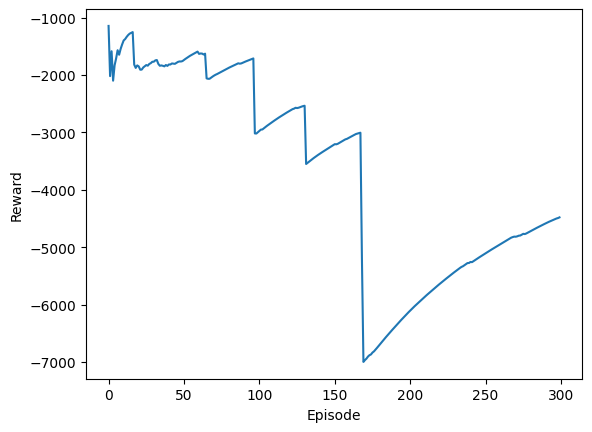

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(300), avg_scores[:300])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

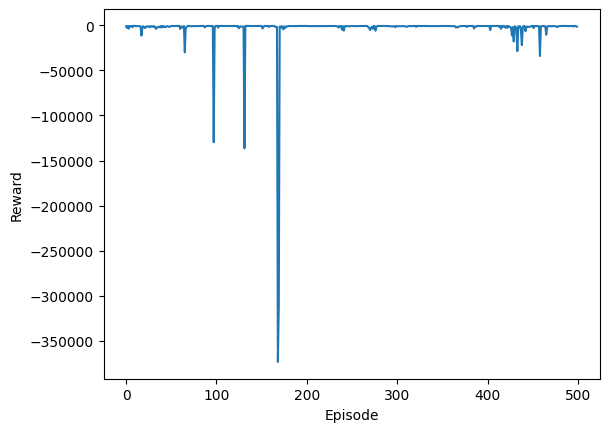

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(score_history)), score_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate(obs, policy_model,angle):
  rewards = []
  control_inputs = []
  states = []

  for _ in range(1):
    obs = cObject.reset()
    obs[2] = angle
    done = False
    episode_rewards = []
    episode_control_inputs = []
    episode_states = []
    count=0
    while not done:
        count+=1
        act = policy_model.choose_action(obs)
        new_state, reward, done, info = cObject.step(act)
        new_state = new_state.ravel()
        reward = reward[0]
        episode_rewards.append(reward)
        episode_control_inputs.append(act)
        episode_states.append(obs)
        obs = new_state

    rewards.append(sum(episode_rewards))
    control_inputs.append(np.array(episode_control_inputs))
    states.append(np.array(episode_states))
  return rewards, control_inputs, states






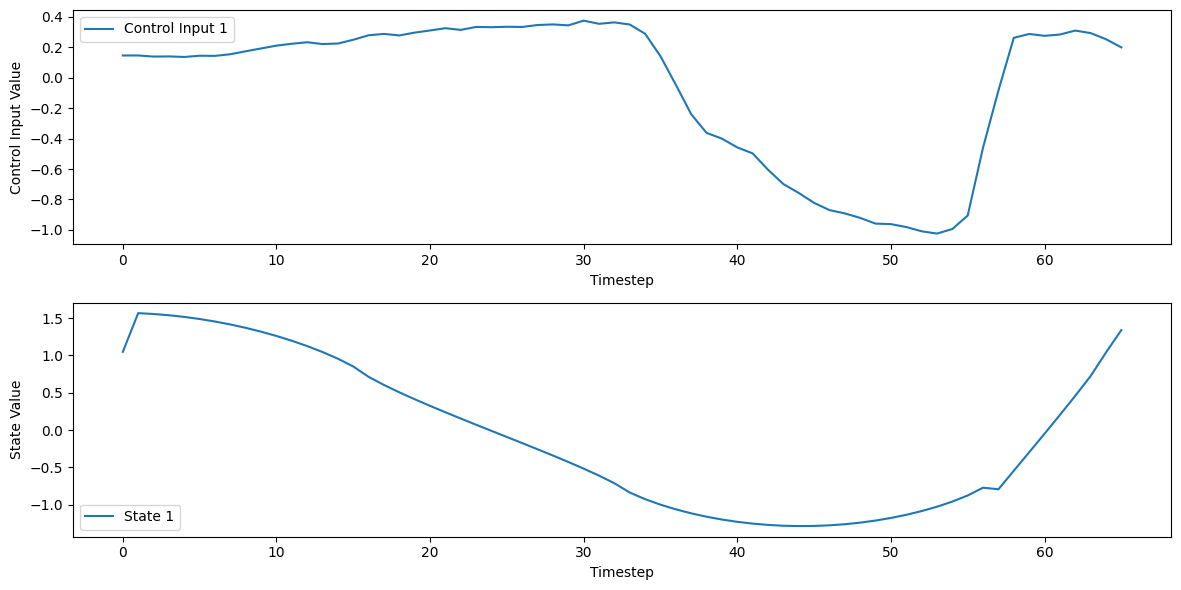

In [ ]:
rewards, control_inputs, states = evaluate(cObject, agent,1.0472)

# Assuming 'episode_idx' is the index of the chosen episode
episode_ctrl_inputs = control_inputs[0]
episode_states = states[0]
plt.figure(figsize=(12, 6))

# Control input plot
plt.subplot(211)
# for dim in range(len(episode_ctrl_inputs)):  # Assuming multiple dimensions
plt.plot(episode_ctrl_inputs, label=f'Control Input {1}')
plt.xlabel('Timestep')
plt.ylabel('Control Input Value')
plt.legend()

# State plot (assuming multiple dimensions)
plt.subplot(212)
# for dim in range(len(episode_states[0])):
plt.plot(episode_states[:,2], label=f'State {1}')
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

plt.tight_layout()
plt.show()


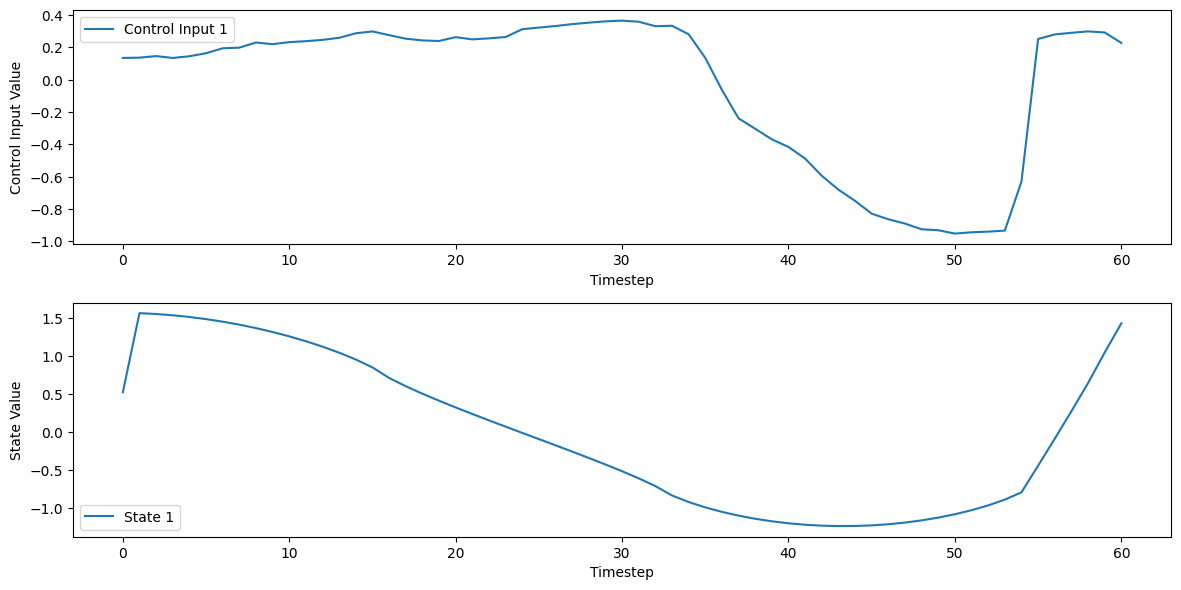

In [ ]:
rewards, control_inputs, states = evaluate(cObject, agent,0.5236)
# Assuming 'episode_idx' is the index of the chosen episode
episode_ctrl_inputs = control_inputs[0]
episode_states = states[0]
plt.figure(figsize=(12, 6))

# Control input plot
plt.subplot(211)
# for dim in range(len(episode_ctrl_inputs)):  # Assuming multiple dimensions
plt.plot(episode_ctrl_inputs, label=f'Control Input {1}')
plt.xlabel('Timestep')
plt.ylabel('Control Input Value')
plt.legend()

# State plot (assuming multiple dimensions)
plt.subplot(212)
# for dim in range(len(episode_states[0])):
plt.plot(episode_states[:,2], label=f'State {1}')
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

plt.tight_layout()
plt.show()


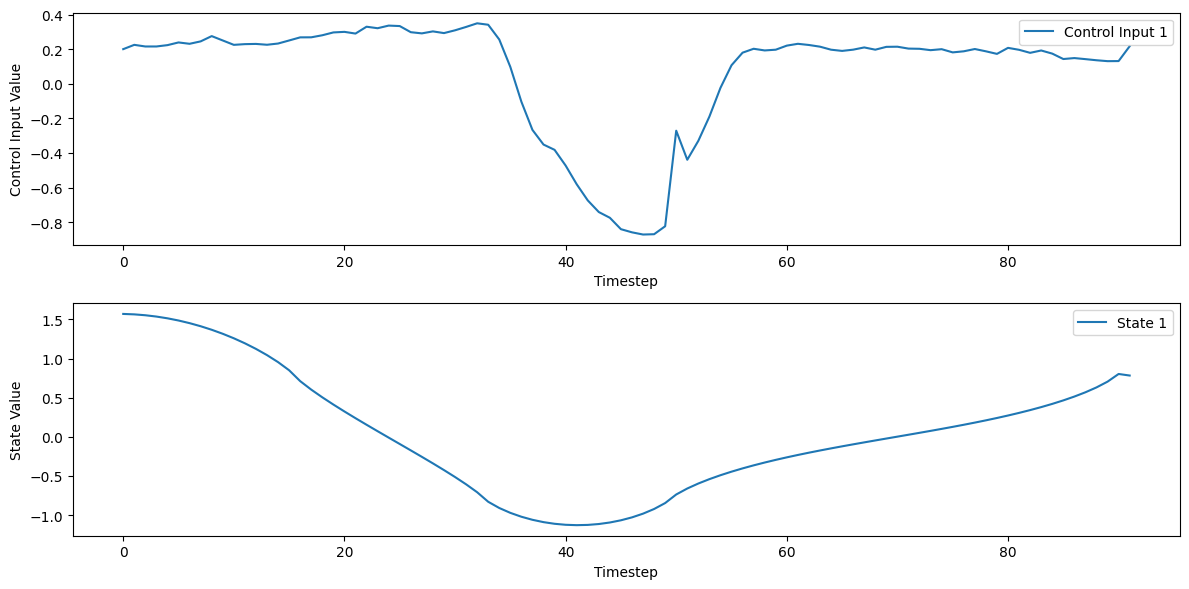

In [ ]:
rewards, control_inputs, states = evaluate(cObject, agent,1.5708)
# Assuming 'episode_idx' is the index of the chosen episode
episode_ctrl_inputs = control_inputs[0]
episode_states = states[0]
plt.figure(figsize=(12, 6))
# print(states[0])
# print(episode_states[:,0])
# Control input plot
plt.subplot(211)
# for dim in range(len(episode_ctrl_inputs)):  # Assuming multiple dimensions
plt.plot(episode_ctrl_inputs, label=f'Control Input {1}')
plt.xlabel('Timestep')
plt.ylabel('Control Input Value')
plt.legend()

# State plot (assuming multiple dimensions)
plt.subplot(212)
# for dim in range(len(episode_states[0])):
plt.plot(episode_states[:,2], label=f'State {1}')
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

plt.tight_layout()
plt.show()
